In [1]:
pip install xgboost

In [2]:
!python -m pip install scikit-learn==1.5.1 --upgrade
import sklearn
print(sklearn.__version__)

1.5.1


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
path =r"C:\Users\ObaloluwaOluokun\Downloads\loan_approval_dataset.csv"
loan_df = pd.read_csv(path)
loan_df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
loan_df.columns = loan_df.columns.str.strip()
loan_df["loan_status"] = loan_df["loan_status"].str.strip()

In [6]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


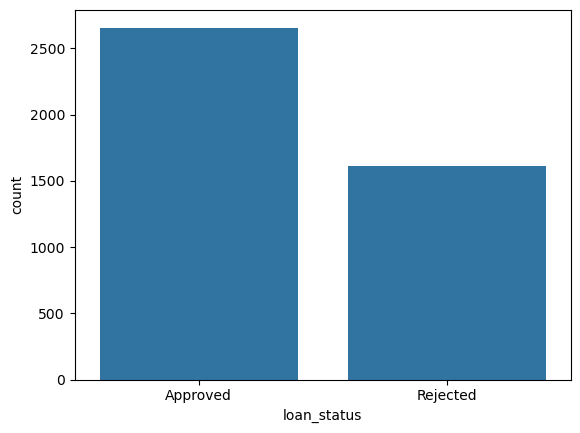

In [7]:
loan_df["loan_status"].value_counts()
sns.countplot(x = "loan_status", data = loan_df)
plt.show()

In [8]:
loan_df["loan_status"] = loan_df["loan_status"].map({
    "Rejected": 0,
    "Approved": 1
})

In [9]:
X = loan_df.drop(columns =["loan_status", "loan_id"])
Y = loan_df["loan_status"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42, stratify = Y)

In [10]:
num_var = X_train.select_dtypes(include = ["int"]).columns
cat_var = X_train.select_dtypes(include = ["object"]).columns

In [11]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_var),
    ("car", OneHotEncoder(), cat_var)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("Classifier", XGBClassifier(
        random_state = 42, eval_metric = "logloss"
    ))
])

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [12]:
param_grid = {
    "Classifier__n_estimators": [100, 200, 300],
    "Classifier__max_depth": [3, 5],
    "Classifier__learning_rate": [0.05, 0.1],
    "Classifier__scale_pos_weight": [0.5, 1, 1.5]
}

model = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv = cv,
    scoring = "accuracy",
    verbose = 2,
    n_jobs = -1
)

In [13]:
model.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
       'cibil_score', 'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value'],
      dty...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'Classifier__learning_rate': [0.05, 0.1],
                         'Classifier__max_depth': [3, 5],
                         'Classifier__n_estimators': [100, 200, 300],
                         'Classifier__scale_pos_weight': [0.5, 1, 1.5]},
             scoring='accuracy', verbose=2)

In [14]:
Y_pred =model.predict(X_test)

In [15]:
best_model = model.best_estimator_
xgb_best = best_model.named_steps["Classifier"]


In [16]:
num_feature = num_var
cat_feature = best_model.named_steps["preprocessor"].named_transformers_["car"].get_feature_names_out(cat_var)
all_features = np.concatenate([num_feature, cat_feature])

In [17]:
importance = xgb_best.feature_importances_
indices = np.argsort(importance)


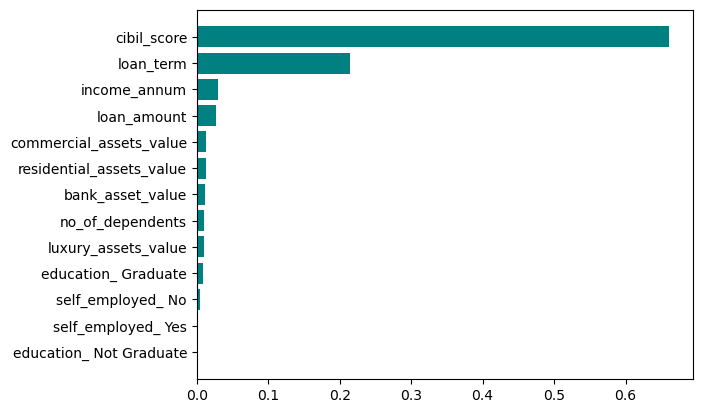

In [18]:
plt.barh(all_features[indices], importance[indices], color = "teal")
plt.show()

In [19]:
Accuracy = accuracy_score(Y_test, Y_pred)
Classification_Report = classification_report(Y_test, Y_pred)
Confusion_Matrix = confusion_matrix(Y_test, Y_pred)
print (Classification_Report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       484
           1       0.99      0.99      0.99       797

    accuracy                           0.99      1281
   macro avg       0.98      0.98      0.98      1281
weighted avg       0.99      0.99      0.99      1281



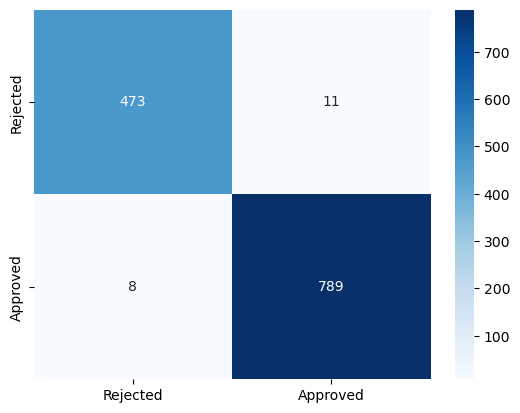

In [20]:
sns.heatmap(Confusion_Matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["Rejected", "Approved"], yticklabels = ["Rejected", "Approved"])
plt.show()

In [21]:
import joblib

joblib.dump(best_model, "loan_approval_model.pkl")
# Extract feature names from X_train
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# Save feature names separately
joblib.dump(num_features, "num_features.pkl")
joblib.dump(cat_features, "cat_features.pkl")



['cat_features.pkl']